In [1]:
# data = pd.read_csv(r'c:\Github\Sol\the_data\data-lab-3-insurance.csv')
# data.info()

In [2]:
import pandas as pd 
import numpy as np 
import seaborn as sns
sns.set(style='dark', palette='muted', color_codes=True)
import plotly.express as px
import matplotlib.pyplot as plt 
plt.style.use('ggplot')

In [3]:
from sklearn.impute import SimpleImputer 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler 
from sklearn.linear_model import LinearRegression, LogisticRegression 
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor 
from sklearn.metrics import r2_score, mean_squared_error, silhouette_score, confusion_matrix, accuracy_score 
from sklearn.decomposition import PCA 
from sklearn.pipeline import Pipeline 
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier 
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer

In [4]:
data = pd.read_csv(r'c:\Github\Sol\the_data\data-lab-3-insurance.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
mis_col = data.isna().sum() * 100/len(data)

mis_col.sort_values(ascending=False)

age         0.0
sex         0.0
bmi         0.0
children    0.0
smoker      0.0
region      0.0
charges     0.0
dtype: float64

In [6]:
data.duplicated().sum()

data.drop_duplicates(keep='first', subset=None, inplace=True, ignore_index=False)
data.duplicated().sum()

0

<AxesSubplot:title={'center':'Correlation Matrix'}>

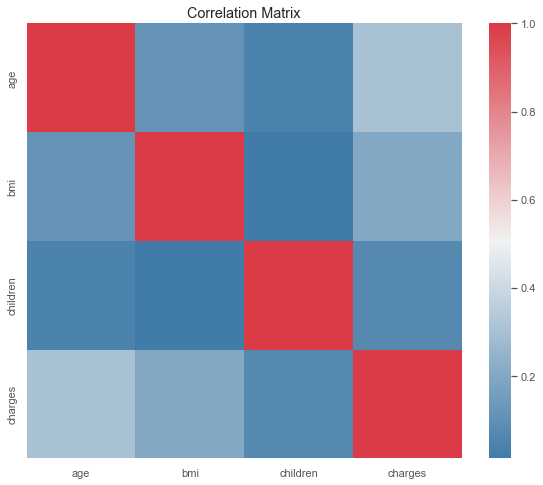

In [7]:
data_corr = data.corr()

f,ax = plt.subplots(figsize=(10,8))

ax.set_title('Correlation Matrix')

sns.heatmap(data_corr, mask=np.zeros_like(data_corr, dtype=np.bool_), cmap=sns.diverging_palette(240,10, as_cmap=True), ax=ax, square=True)

In [8]:
orig_reg = data.region

In [9]:
le = LabelEncoder()

data.sex = le.fit_transform(data.sex)
data.region = le.fit_transform(data.region)
data.smoker = le.fit_transform(data.smoker)
data.head(2)

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.90,0,1,3,16884.9240
1,18,1,33.77,1,0,2,1725.5523


In [10]:
le_reg = data.region

orig_reg_dic = np.unique(orig_reg)
le_reg_dic = np.unique(le_reg)

reg_dic = dict(zip(orig_reg_dic, le_reg_dic))
reg_dic

{'northeast': 0, 'northwest': 1, 'southeast': 2, 'southwest': 3}

In [11]:
y = data.charges
x = data.drop(columns=['charges'])


In [12]:
scaler = StandardScaler()

x = pd.DataFrame(scaler.fit_transform(x))

y = scaler.fit_transform(np.array(y).reshape(-1,1))

In [13]:
x_train,x_test,y_train,y_test = train_test_split(x,y, random_state=42, test_size=0.3)

In [14]:
linreg = LinearRegression()

linreg.fit(x_train,y_train)

y_true = y_test 
y_pred = linreg.predict(x_test)

scr_r2 = r2_score(y_true,y_pred).round(3)

scr_mse = mean_squared_error(y_true, y_pred).round(3)

mod_perf = pd.DataFrame( 
    [ 
        'LinearRegression', scr_r2, scr_mse
    ]
).transpose()

mod_perf.colums = ['Method', 'Test R2', 'Test MSE']

mod_perf

C:\Users\amunv\AppData\Local\Temp\ipykernel_7900\3425073942.py:18: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  mod_perf.colums = ['Method', 'Test R2', 'Test MSE']


,0,1,2
0,LinearRegression,0.772,0.266


In [15]:
ranfor = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42, criterion='squared_error')

ranfor.fit(x_train,y_train)

y_pred = ranfor.predict(x_test)



scr_r2ranfor = r2_score(y_true,y_pred).round(3)

scr_mseranfor = mean_squared_error(y_true, y_pred).round(3)

mod_perf = pd.DataFrame( 
    [ 
        'LinearRegression', scr_r2ranfor, scr_mseranfor
    ]
).transpose()

mod_perf.colums = ['Method', 'Test R2', 'Test MSE']

mod_perf

C:\Users\amunv\AppData\Local\Temp\ipykernel_7900\2703673571.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  ranfor.fit(x_train,y_train)
C:\Users\amunv\AppData\Local\Temp\ipykernel_7900\2703673571.py:19: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  mod_perf.colums = ['Method', 'Test R2', 'Test MSE']


,0,1,2
0,LinearRegression,0.863,0.16
